In [586]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.distributions import MultivariateNormal, Normal
from torchvision.transforms import ToTensor

from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *

In [587]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

%load_ext autoreload
%autoreload 2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [588]:
#DEVICE = 'cpu'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [589]:
DATAPATH = 'C:/Users/matan/Documents/data/coil-20-proc'
root_dir = DATAPATH + '/coil-20-proc'
csv_file = 'C:/Users/matan/Documents/data/coil-20-proc/labels.csv'

In [590]:
df = pd.read_csv(csv_file)

In [591]:
class COIL20(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        self.labels = range(1,21)
        self.objects = ["Rubber duck",
            "Wooden toy 1",
            "Toy car 1",
            "Lucky cat",
            "Anacin",
            "Toy car 2",
            "Wooden toy 2",
            "Johnsons baby powder",
            "Tylenol",
            "Vaseline",
            "Wooden toy 3",
            "Chinese cup",
            "Piggy bank",
            "Connector",
            "Plastic container",
            "Conditioner bottle",
            "Ceramic pot",
            "Teacup",
            "Toy car 3",
            "Philadelphia"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image'], row['label']
        img_filename = self.root_dir + '/' + str(img_id)
        img = Image.open(img_filename)
        if self.transform:
            img = self.transform(img)
        return img, img_label

Number of images in the dataset:  1440
Image shape: torch.Size([1, 128, 128])


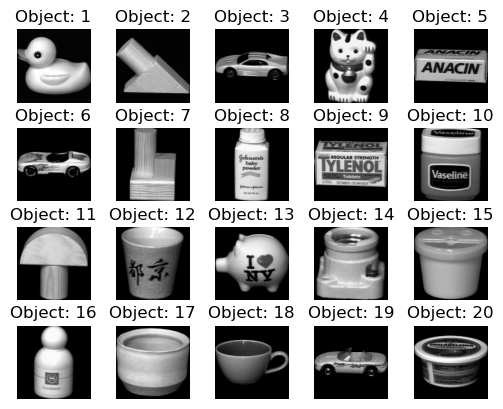

In [592]:
dataset = COIL20(root_dir, csv_file, transform=ToTensor())
print("Number of images in the dataset: ", len(dataset))
img, label = dataset[0]
print("Image shape:", img.shape)

indices = {}
i = 0
while len(indices) < 20:
    _, label = dataset[i]
    if label not in indices.keys():
        indices[label] = i
    i += 1
    
fig = plt.figure()
gs = fig.add_gridspec(4,5, hspace=0.35, wspace=0)
axs = gs.subplots()
for l in range(20):
    img, label = dataset[indices[l+1]]
    assert label == l + 1
    r, c = (l)//5, l%5
    #print("label:", label, "row:", r, "col:", c)
    axs[r,c].imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
    axs[r,c].set_title("Object: " + str(label))
    axs[r,c].axis('off')
plt.show()

# Set parameters

In [593]:
# Hyperparameters
batch_size = 64
lr = 0.001

N = len(dataset)
in_channels = 1
input_size = [in_channels, 128, 128]
dim_input = np.prod(input_size)
dim_hidden = 1024
dim_latent = 4
n_classes = 20
seed = 11       # Random seed for reproducible results
torch.manual_seed(seed);

In [594]:
# Divide into train, test, and val
test_size = int(0.1*N)
val_size = int(0.1*N)
train_size = N - test_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
print("Training images: ", len(train_data))
print("Validation images: ", len(val_data))
print("Test images: ", len(test_data))

#kwargs = {'num_workers': 1, 'pin_memory': True} 
kwargs = {}
train_loader = DataLoader(train_data, batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, len(test_data), shuffle=True, **kwargs)
val_loader = DataLoader(val_data, len(val_data), **kwargs)

Training images:  1152
Validation images:  144
Test images:  144


In [595]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

# Make and train VAE model

In [596]:
from multiprocessing import reduction


class Encoder(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_latent):
        super(Encoder, self).__init__()
        self.dim_input = dim_input
        self.dim_hidden = dim_hidden
        self.dim_latent = dim_latent

        self.fc1 = nn.Linear(dim_input, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.mu = nn.Linear(dim_hidden, dim_latent)
        self.var = nn.Linear(dim_hidden, dim_latent)

        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)   # Flatten image
        h1 = self.activation(self.fc1(x))
        h1 = self.activation(self.fc2(h1))
        return self.mu(h1), self.var(h1)


class Decoder(nn.Module):
    def __init__(self, dim_latent, dim_hidden, dim_input):
        super(Decoder, self).__init__()
        self.dim_input = dim_input
        self.dim_hidden = dim_hidden
        self.dim_latent = dim_latent

        self.fc1 = nn.Linear(dim_latent, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.fc3 = nn.Linear(dim_hidden, dim_input)
        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()

    def forward(self, z):
        h1 = self.activation(self.fc1(z))
        h1 = self.activation(self.fc2(h1))
        #return self.mu(h1), self.var(h1)
        return torch.tanh(self.fc3(h1))


class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

        self.dim_input = Encoder.dim_input
        self.dim_hidden = Encoder.dim_hidden
        self.dim_latent = Encoder.dim_latent

    def reparametrization(self, mean, var):
        eps = torch.randn_like(var).to(DEVICE) # Ransom tensor in same shape as var
        z = mean + var*eps
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

    def get_latents(self, x):
        """ Encode data x into latent representations z. """
        mean, log_var = self.Encoder(x)
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        return z


def loss_function(x, out, mean, log_var, beta = 1):
    """ Loss function for the model. """
    x_hat=out
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    KL_divergence = KL_divergence * beta
    #print("Loss:", reproduction_loss, KL_divergence)
    return reproduction_loss + KL_divergence, reproduction_loss, KL_divergence

In [597]:
def beta_func(step, start=200, stop=400, scale=0.8):
    if step < start:
        return 0
    elif step > stop:
        return scale
    else: 
        return scale * (step - start)/(stop - start)

In [598]:
encoder = Encoder(dim_input, dim_hidden, dim_latent).to(DEVICE)
decoder = Decoder(dim_latent, dim_hidden, dim_input).to(DEVICE)
model = Model(encoder, decoder).to(DEVICE)
optimizer = Adam(model.parameters(), lr=lr)
print(DEVICE)

cuda


In [599]:
# Train the model
epochs = 200
validation_loss = []
train_losses = []
train_r_losses = []
train_kl_losses = []
beta_vals = []
step = 0
for epoch in range(epochs):
    model.train()
    loss_this_epoch = 0
    r_loss_this_epoch = 0
    kl_loss_this_epoch = 0
    for batch, (x, label) in enumerate(train_loader):
        batch_size = x.shape[0]
        x = x.view(batch_size, dim_input)   # Flatten
        x = x.to(DEVICE)

        assert not torch.isnan(x).any()
        optimizer.zero_grad()

        out, mean, logvar = model(x)
        x_hat = out

        if torch.isnan(x_hat.view(-1)).sum().item() != 0:
            print("Number of nans:", torch.isnan(x_hat.view(-1)).sum().item())
            print(x_hat)
        assert not torch.isnan(x_hat).any()
        
        #loss = loss_function(x, out, q_mean, q_log_var)
        beta = 1#beta_func(step)
        loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=beta)
        loss_this_epoch += loss.item() 
        r_loss_this_epoch += r_loss.item()
        kl_loss_this_epoch += kl.item()
        beta_vals.append(beta)
        step += 1


        loss.backward()
        optimizer.step()

    train_losses.append(loss_this_epoch / ((batch+1)*batch_size))
    train_r_losses.append(r_loss_this_epoch / ((batch+1)*batch_size))
    train_kl_losses.append(kl_loss_this_epoch / ((batch+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss_this_epoch / ((batch+1)*batch_size))
    print("\t\t\t\tReproduction loss:", r_loss_this_epoch / ((batch+1)*batch_size) ,"\tKL-div:", kl_loss_this_epoch / ((batch+1)*batch_size))

    model.eval()
    with torch.no_grad():
        for batch, (x, label) in enumerate(val_loader):
            batch_size = x.shape[0]
            x = x.view(batch_size, dim_input)   # Flatten
            x = x.to(DEVICE)
            x_hat, q_mean, q_log_var = model(x)
            loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=1)
            validation_loss.append(loss.item() / len(val_data))

	Epoch 1 complete! 	Average Loss:  2445.1607462565103
				Reproduction loss: 2403.6766967773438 	KL-div: 41.48403378068987
	Epoch 2 complete! 	Average Loss:  923.1102905273438
				Reproduction loss: 907.5853949652778 	KL-div: 15.524906052483452
	Epoch 3 complete! 	Average Loss:  741.3963826497396
				Reproduction loss: 725.865478515625 	KL-div: 15.530898518032497
	Epoch 4 complete! 	Average Loss:  685.1816880967882
				Reproduction loss: 668.9753044976128 	KL-div: 16.206386778089737
	Epoch 5 complete! 	Average Loss:  616.9343973795573
				Reproduction loss: 601.2239786783854 	KL-div: 15.710413614908854
	Epoch 6 complete! 	Average Loss:  555.3759833441841
				Reproduction loss: 539.8319261338976 	KL-div: 15.544060283237034
	Epoch 7 complete! 	Average Loss:  538.6355353461372
				Reproduction loss: 523.1925116644966 	KL-div: 15.443029615614149
	Epoch 8 complete! 	Average Loss:  498.46027289496527
				Reproduction loss: 482.8989546034071 	KL-div: 15.561318079630533
	Epoch 9 complete! 	Ave

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


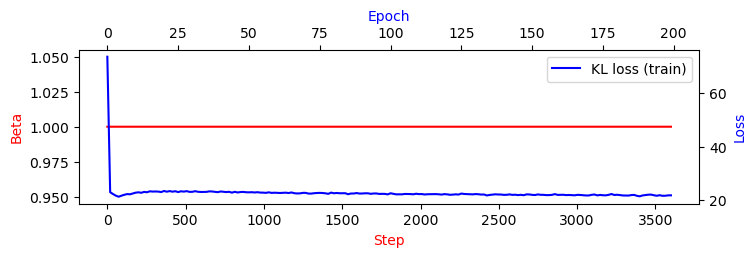

In [ ]:
fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(111, label='1')
ax2 = fig.add_subplot(111, label='2', frame_on=False)

ax1.plot(range(step), beta_vals, color='red', label = "Beta")
ax1.set_xlabel("Step", color='red')
ax1.set_ylabel("Beta", color='red')
plt.legend()

ax2.plot(range(epochs), train_kl_losses, color='blue', label = "KL loss (train)")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel("Epoch", color='blue')
ax2.set_ylabel("Loss", color='blue')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
plt.legend()
plt.show()

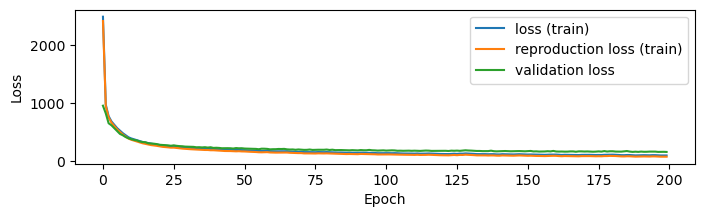

In [ ]:
plt.figure(figsize=(8,2))
plt.plot(range(epochs), train_losses, label = "loss (train)")
plt.plot(range(epochs), train_r_losses, label = "reproduction loss (train)")
plt.plot(range(epochs), validation_loss, label = 'validation loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

# Evaluate the model

<Figure size 400x200 with 0 Axes>

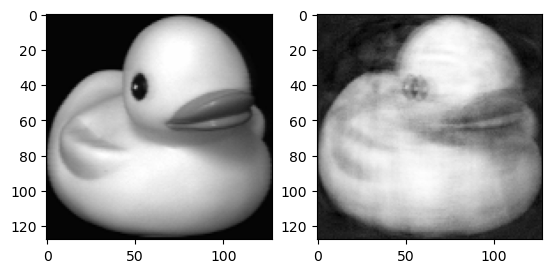

In [ ]:
model.eval()

# See reconstruction of an image in the training set
img, label = train_data[900]
img_repro, _, _ = model(img.to(DEVICE))
img_repro = img_repro.reshape(input_size).cpu().detach()
plt.figure(figsize=(4,2))
fig, axs = plt.subplots(1,2)
axs[0].imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
axs[1].imshow(img_repro.permute(1,2,0), cmap=plt.get_cmap('gray'))
plt.show()

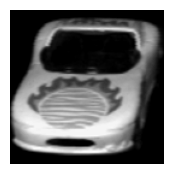

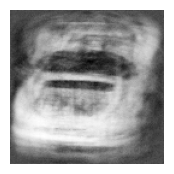

In [ ]:
model.eval()
examples = enumerate(test_loader)
with torch.no_grad():
    batch, (x, labels) = next(examples)
    x = x.view(x.size(0), dim_input)
    x = x.to(DEVICE)
    x_hat, _, _ = model(x)

def show_image_in_batch(images, idx):
    images = images.view(images.shape[0], input_size[-2], input_size[-1])
    fig = plt.figure(figsize=(2,2))
    plt.imshow(images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

show_image_in_batch(x, idx=0)
show_image_in_batch(x_hat, idx=0)

C:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1152 samples in 0.001s...
[t-SNE] Computed neighbors for 1152 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1152
[t-SNE] Computed conditional probabilities for sample 1152 / 1152
[t-SNE] Mean sigma: 1.005105
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.859108
[t-SNE] KL divergence after 1000 iterations: 0.559150


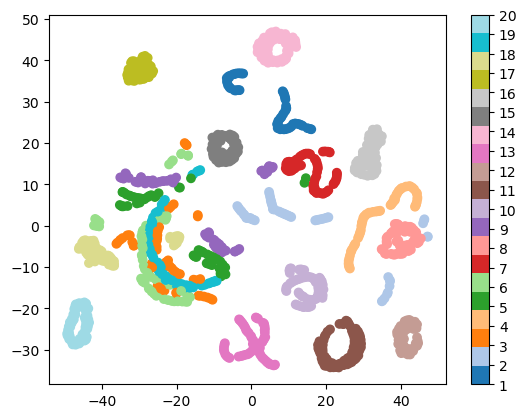

In [ ]:
# Make T-SNE plot
plot_latent_space_tsne(model, train_loader)

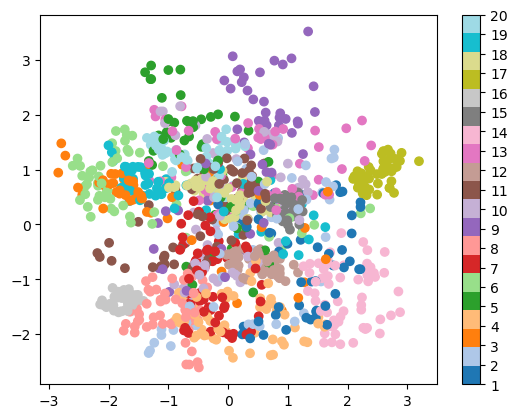

In [ ]:
plot_latent_space_pca(model, train_loader, n_batches=200)

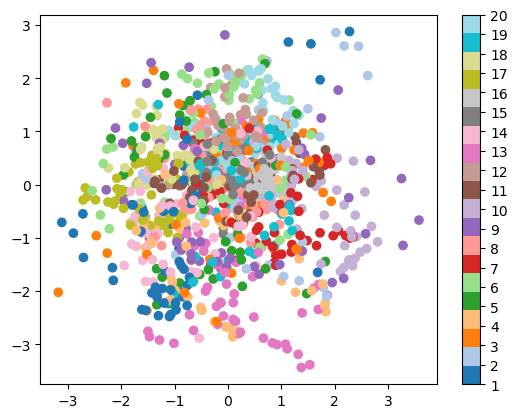

In [ ]:
plot_latent_space2d(model, train_loader, n_batches=200)

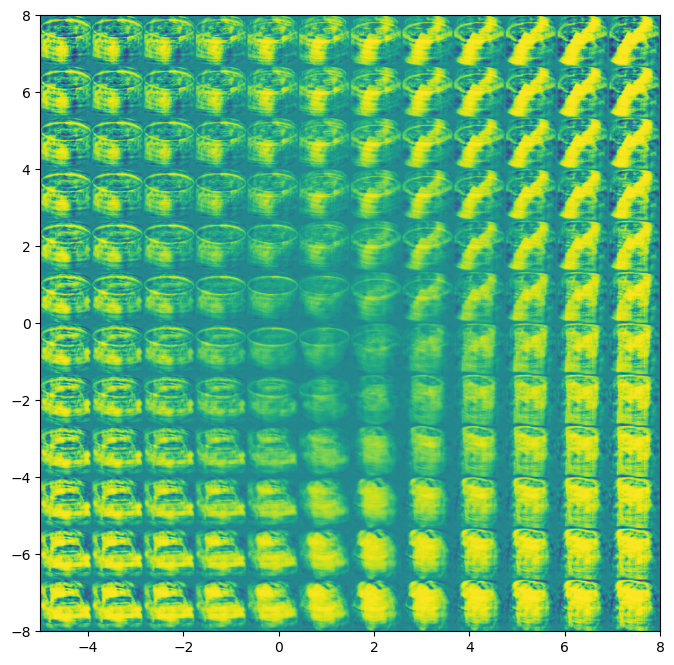

In [ ]:
plot_reconstructed(model, ax0=(-5,8), ax1=(-8,8), dims=[0,1], n=12, img_size=input_size[-2:])

# How does it behave on out-of-distribution images?